In [1]:
# https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?resource=download

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
df = pd.read_csv('../datasets/Twitter_Data.csv')

print(df)
print(f"El dataset tiene {df.shape[0]} filas")
print(f"El dataset tiene {df.isnull().any(axis=1).sum()} filas con valores nulos")
df_clean = df.dropna()
print(f"El dataset tiene {df_clean.isnull().any(axis=1).sum()} filas con valores nulos")

                                               clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...      -1.0
162976  dear rss terrorist payal gawar what about modi...      -1.0
162977  did you cover her interaction forum where she ...       0.0
162978  there big project came into india modi dream p...       0.0
162979  have you ever listen about like gurukul where ...       1.0

[162980 rows x 2 columns]
El dataset tiene 162980 filas
El dataset tiene 11 filas con valores nulos
El dataset tiene 0 filas con valores nulos


<Axes: xlabel='category'>

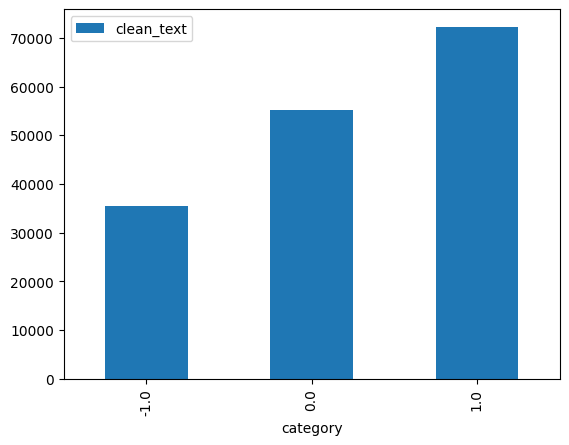

In [4]:
df_clean.groupby('category').count().plot(kind='bar')

C:\Users\hugoc\AppData\Local\Temp\ipykernel_95776\437397031.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_text'] = df_clean['clean_text'].astype(str)


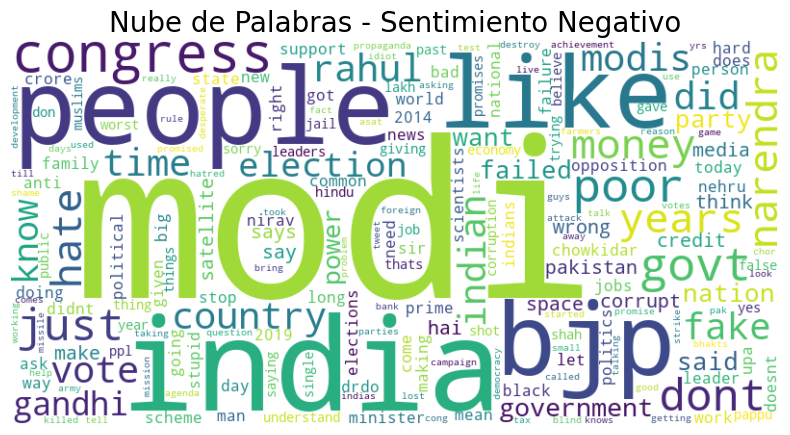

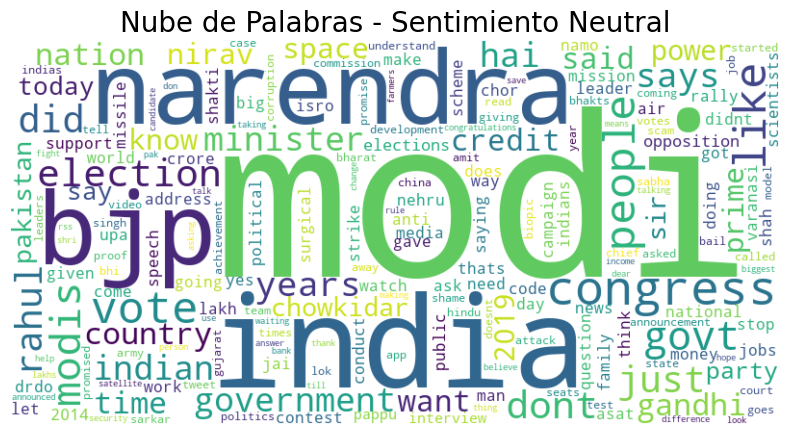

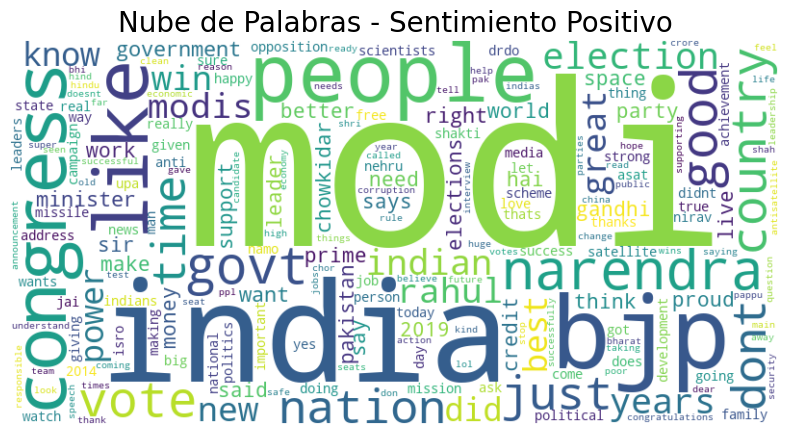

In [5]:

def plot_word_cloud(terms, category):
    # Definir un título basado en el valor de la categoría
    if category == 1.0:
        title = "Positivo"
    elif category == 0.0:
        title = "Neutral"
    else:
        title = "Negativo"
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras - Sentimiento {title}', fontsize=20)  # Añadir título aquí
    plt.axis("off")
    plt.show()

# Asegúrate de que los datos están limpios y los textos son strings
df_clean['clean_text'] = df_clean['clean_text'].astype(str)

# Generar nubes de palabras para cada categoría
for category in [-1.0, 0.0, 1.0]:
    subset = df_clean[df_clean['category'] == category]
    texts = " ".join(subset['clean_text'])
    tfidf_vector = TfidfVectorizer(stop_words='english', max_features=1000)
    X_sub = tfidf_vector.fit_transform([texts])
    max_words = {word: X_sub[0, idx] for word, idx in tfidf_vector.vocabulary_.items()}
    plot_word_cloud(max_words, category)  # Pasar también la categoría como argumento


In [6]:
# Tokenización
tokenizer = Tokenizer(num_words=5000)  # Solo considera las 5000 palabras más frecuentes
tokenizer.fit_on_texts(df_clean['clean_text'])
sequences = tokenizer.texts_to_sequences(df_clean['clean_text'])

In [7]:
# Padding
max_sequence_len = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_len)
y = to_categorical(np.asarray(df_clean['category'] + 1))  # Convertir -1, 0, 1 a 0, 1, 2 para categorías

In [7]:
! python3 -m pip install tensorflow[and-cuda]


import tensorflow as tf

if tf.test.gpu_device_name():
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
Please install GPU version of TF


ERROR: Could not find a version that satisfies the requirement nvidia-nccl-cu12==2.19.3; extra == "and-cuda" (from tensorflow[and-cuda]) (from versions: 0.0.1.dev5)
ERROR: No matching distribution found for nvidia-nccl-cu12==2.19.3; extra == "and-cuda"


In [8]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_sequence_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax')  # 3 categorías de salida
])

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

# Evaluar el modelo
print(model.evaluate(X_test, y_test))


# Evaluar el modelo
print(model.evaluate(X_test, y_test))


Epoch 1/10


c:\Users\hugoc\anaconda3\envs\thefreeai\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3667/3667 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.8190 - loss: 0.4605 - val_accuracy: 0.9498 - val_loss: 0.1832
Epoch 2/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9511 - loss: 0.1790 - val_accuracy: 0.9565 - val_loss: 0.1650
Epoch 3/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9573 - loss: 0.1571 - val_accuracy: 0.9570 - val_loss: 0.1641
Epoch 4/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9609 - loss: 0.1430 - val_accuracy: 0.9584 - val_loss: 0.1649
Epoch 5/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9637 - loss: 0.1273 - val_accuracy: 0.9582 - val_loss: 0.1675
Epoch 6/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9687 - loss: 0.1105 - val_accuracy: 0.9556 - val_loss: 0.1741
Epoch 7/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9717 - loss: 0.0987 - val_accuracy: 0.9541 - val_loss: 0.1850
Epoch 8/10
3667/3667 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9748 - loss: 0.08

In [9]:
# Preparar el nuevo texto para predicción
new_text = ['dont like this shit post']
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_sequence_len)

# Realizar la predicción
pred = model.predict(padded)
print(f'Predicción: {pred[0]}')  # Muestra la probabilidad de cada categoría

# Determinar la categoría más probable
predicted_category_index = np.argmax(pred[0])
categories = {-1: 'Negativo', 0: 'Neutral', 1: 'Positivo'}  # Categorías ajustadas para corresponder a tus etiquetas
predicted_category = categories[predicted_category_index - 1]  # ajustar el índice para -1, 0, 1
print(f'La categoría más probable es: {predicted_category} con una probabilidad de {pred[0][predicted_category_index]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicción: [0.9932065  0.00102985 0.0057637 ]
La categoría más probable es: Negativo con una probabilidad de 0.9932065010070801
